In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import joblib, scipy, sklearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [3]:
# shuffle the DataFrame rows
df = df.sample(frac = 1)

In [4]:
df.drop(['ID'],axis=1,inplace=True)

In [5]:
df.shape

(418, 19)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 42 to 156
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage         

## Checking for percentage of null data in each column

In [7]:
df.isnull().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

## Checking for duplicate data

In [8]:
df[df.duplicated()]

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage


## Feature Engineering

In [9]:
df.Age = (df.Age.values/365.0).round()
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
42,4556,C,D-penicillamine,49.0,F,N,N,N,N,1.1,361.0,3.64,36.0,5430.2,67.08,89.0,203.0,10.6,2.0
125,824,D,D-penicillamine,54.0,F,Y,Y,Y,N,1.2,269.0,3.12,NaN,1441.0,165.85,68.0,166.0,11.1,4.0
389,1419,C,NaN,68.0,M,NaN,NaN,NaN,N,3.0,NaN,3.15,NaN,NaN,NaN,NaN,139.0,10.0,3.0
30,3839,D,Placebo,42.0,F,N,Y,N,N,4.7,296.0,3.44,114.0,9933.2,206.40,101.0,195.0,10.3,2.0
37,3244,D,Placebo,37.0,F,N,Y,Y,N,3.3,383.0,3.53,102.0,1234.0,137.95,87.0,234.0,11.0,4.0


In [10]:
df[400:]

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
45,2256,D,D-penicillamine,46.0,F,N,Y,N,N,5.7,482.0,2.84,161.0,11552.0,136.74,165.0,518.0,12.7,3.0
391,1368,C,NaN,69.0,F,NaN,NaN,NaN,N,0.4,NaN,3.03,NaN,NaN,NaN,NaN,173.0,10.9,3.0
172,2657,C,D-penicillamine,30.0,F,N,Y,Y,N,3.0,236.0,3.42,76.0,1403.0,89.90,86.0,493.0,9.8,2.0
159,2772,C,Placebo,57.0,F,N,N,N,N,0.6,217.0,3.62,13.0,414.0,75.95,119.0,224.0,10.5,3.0
285,1408,C,D-penicillamine,39.0,F,N,Y,Y,N,2.0,310.0,3.36,70.0,1257.0,122.00,118.0,143.0,9.8,3.0
210,2195,C,Placebo,53.0,F,N,N,N,N,1.3,NaN,3.76,27.0,1282.0,100.75,NaN,114.0,10.3,3.0
24,4127,C,Placebo,45.0,F,N,N,N,N,0.7,298.0,4.10,40.0,661.0,106.95,66.0,324.0,11.3,2.0
218,2157,C,Placebo,43.0,F,N,N,N,N,1.6,215.0,4.17,67.0,936.0,134.85,85.0,176.0,9.6,3.0
92,3913,C,D-penicillamine,37.0,F,N,N,N,N,1.3,353.0,3.67,73.0,2039.0,232.50,68.0,380.0,11.1,2.0
0,400,D,D-penicillamine,59.0,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0


### Imputation of missing values

In [27]:
df['Drug'].fillna(method='ffill', inplace=True)
df['Ascites'].fillna(df['Ascites'].mode()[0], inplace=True)
df['Hepatomegaly'].fillna(df['Hepatomegaly'].mode()[0], inplace=True)
df['Spiders'].fillna(df['Spiders'].mode()[0], inplace=True)
df['Cholesterol'].fillna(df['Cholesterol'].mode()[0], inplace=True)
df['SGOT'].fillna(df['SGOT'].mode()[0], inplace=True)
df['Copper'].fillna(df['Copper'].mode()[0], inplace=True)
df['Alk_Phos'].fillna(df['Alk_Phos'].mode()[0], inplace=True)
df['Tryglicerides'].fillna(df['Tryglicerides'].mode()[0], inplace=True)
df['Platelets'].fillna(df['Platelets'].mean(), inplace=True)
df['Prothrombin'].fillna(df['Prothrombin'].mean(), inplace=True)
df['Stage'].fillna(method='ffill',inplace=True)


### Treatment of outliers

In [28]:
for col in df.columns:
    if df[col].dtypes != 'object':
        lower_limit, upper_limit = df[col].quantile([0.25,0.75])
        IQR = upper_limit - lower_limit
        lower_whisker = lower_limit - 1.5 * IQR
        upper_whisker = upper_limit + 1.5 * IQR
        df[col] = np.where(df[col]>upper_whisker,upper_whisker,np.where(df[col]<lower_whisker,lower_whisker,df[col]))

### Encoding of categorical features

In [29]:
df.Sex.replace(['M','F'],[1,0],inplace=True)
df.Sex = df.Sex.astype(np.float64)
df.Edema.replace(['N','S','Y'],[0,-1,1],inplace=True)
df.Edema = df.Edema.astype(np.float64)
df.Ascites.replace(['Y','N'],[1,0],inplace=True)
df.Hepatomegaly.replace(['Y','N'],[1,0],inplace=True)
df.Spiders.replace(['Y','N'],[1,0],inplace=True)
df.Ascites = df.Ascites.astype(np.float64)
df.Hepatomegaly = df.Hepatomegaly.astype(np.float64)
df.Spiders = df.Spiders.astype(np.float64)
df.Drug.replace(['D-penicillamine','Placebo'],[0,1],inplace=True)
df.Drug = df.Drug.astype(np.float64)
df.Stage = df.Stage.astype(np.int64)

## Separating the independent predictor features and the target label

### We will not be using 'Status' and 'N_days' as our features since they will cause data leakage.

In [32]:
X = df.drop(['Stage','N_Days','Status'],axis=1)
y = df.Stage

## Balancing the imbalanced target column "Stage" using Synthetic Minority Over-Sampling Technique(SMOTE)

In [33]:
smote = SMOTE()
X,y = smote.fit_resample(X,y)

<Axes: ylabel='count'>

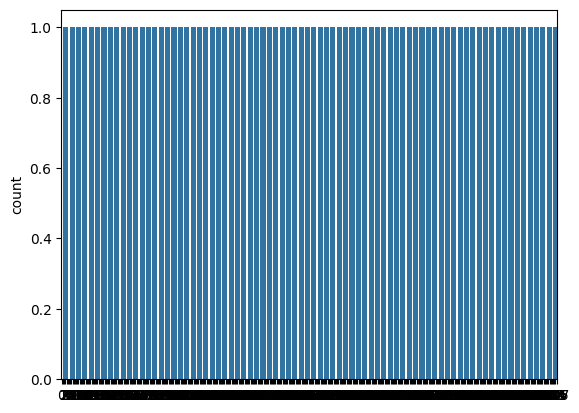

In [25]:
sns.countplot(y)

## Feature Scaling

In [34]:
scaler = StandardScaler()
features = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=features)
X.head()

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,-0.980904,-0.106961,0.0,0.0,-1.149826,0.0,0.0,-0.528169,0.851351,0.213692,-0.812150,2.477557,-0.773259,-0.772774,-0.688231,-0.056701
1,-0.980904,0.401600,0.0,0.0,0.936439,0.0,0.0,-0.481074,-0.309195,-1.153110,-0.445930,0.227043,1.457699,-1.458781,-1.101985,0.562155
2,-0.980904,1.825571,0.0,0.0,0.936439,0.0,0.0,0.366620,-0.422726,-1.074256,-0.445930,-0.770483,-0.677940,0.174570,-1.403914,-0.799328
3,1.144012,-0.818946,0.0,0.0,0.936439,0.0,0.0,1.167221,0.031400,-0.312001,0.973171,2.477557,2.373618,-0.380770,-0.777691,-0.428014
4,1.144012,-1.327507,0.0,0.0,0.936439,0.0,0.0,0.507903,1.128873,-0.075439,0.698506,-0.007070,0.827510,-0.838108,-0.341572,0.438384


## Model Training & Evaluation

## Dividing the dataset into training and test sets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

# Initialize classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(kernel='rbf', random_state=42)
cb = CatBoostClassifier()
cb.fit(X_train,y_train)
# Training the classifiers
rf_classifier.fit(X_train, y_train)
gb_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
# Making predictions
rf_predictions = rf_classifier.predict(X_test)
gb_predictions = gb_classifier.predict(X_test)
svm_predictions = svm_classifier.predict(X_test)
cb_pred=cb.predict(X_test)
# Accuracy of each classifier
rf_accuracy = accuracy_score(y_test, rf_predictions)
gb_accuracy = accuracy_score(y_test, gb_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)
cb_acc=accuracy_score(y_test,cb_pred)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Gradient Boosting Classifier Accuracy:", gb_accuracy)
print("Support Vector Machine Classifier Accuracy:", svm_accuracy)
print("cb_acc")
# Creating the stacking ensemble
estimators = [
    ('rf', rf_classifier),
    ('gb', gb_classifier),
    ('svm', svm_classifier),
    ('cboost',cb)
]
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
# Training the stacking ensemble
stacking_classifier.fit(X_train, y_train)
# Making predictions with stacking ensemble
stacking_predictions = stacking_classifier.predict(X_test)
# Accuracy of stacking ensemble
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
print("Stacking Ensemble Classifier Accuracy:", stacking_accuracy)


Learning rate set to 0.076394
0:	learn: 1.3549028	total: 9.51ms	remaining: 9.5s
1:	learn: 1.3246734	total: 16.2ms	remaining: 8.11s
2:	learn: 1.2962601	total: 22ms	remaining: 7.31s
3:	learn: 1.2626633	total: 27.6ms	remaining: 6.87s
4:	learn: 1.2332829	total: 32.7ms	remaining: 6.5s
5:	learn: 1.2082835	total: 37.8ms	remaining: 6.26s
6:	learn: 1.1832085	total: 42ms	remaining: 5.96s
7:	learn: 1.1676092	total: 46.4ms	remaining: 5.76s
8:	learn: 1.1471166	total: 50.8ms	remaining: 5.59s
9:	learn: 1.1249696	total: 54.8ms	remaining: 5.42s
10:	learn: 1.1038136	total: 58.8ms	remaining: 5.29s
11:	learn: 1.0888174	total: 63.1ms	remaining: 5.19s
12:	learn: 1.0712675	total: 67.4ms	remaining: 5.11s
13:	learn: 1.0561752	total: 71.6ms	remaining: 5.04s
14:	learn: 1.0436159	total: 75.5ms	remaining: 4.96s
15:	learn: 1.0319433	total: 79.4ms	remaining: 4.88s
16:	learn: 1.0150642	total: 83.4ms	remaining: 4.82s
17:	learn: 1.0011683	total: 87.5ms	remaining: 4.77s
18:	learn: 0.9896064	total: 91.3ms	remaining: 4.71

## Logistic Regression

In [684]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [685]:
y_pred = logmodel.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.58      0.71      0.64        31
           2       0.47      0.18      0.26        39
           3       0.37      0.29      0.33        34
           4       0.35      0.68      0.46        25

    accuracy                           0.43       129
   macro avg       0.44      0.47      0.42       129
weighted avg       0.45      0.43      0.41       129



In [686]:
svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [687]:
svm_pred = svm.predict(X_test)
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           1       0.80      0.90      0.85        31
           2       0.64      0.41      0.50        39
           3       0.52      0.47      0.49        34
           4       0.50      0.76      0.60        25

    accuracy                           0.61       129
   macro avg       0.61      0.64      0.61       129
weighted avg       0.62      0.61      0.60       129



In [688]:
scores = []
for i in np.arange(1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    scores.append(knn.score(X_test,y_test))

In [689]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=17)

In [690]:
knn_pred = knn.predict(X_test)
print(confusion_matrix(y_test,knn_pred))
print(classification_report(y_test,knn_pred))

[[29  1  1  0]
 [13 16  4  6]
 [ 7  7 10 10]
 [ 2  3  3 17]]
              precision    recall  f1-score   support

           1       0.57      0.94      0.71        31
           2       0.59      0.41      0.48        39
           3       0.56      0.29      0.38        34
           4       0.52      0.68      0.59        25

    accuracy                           0.56       129
   macro avg       0.56      0.58      0.54       129
weighted avg       0.56      0.56      0.53       129



In [691]:
sgd = SGDClassifier()
sgd.fit(X_train,y_train)

SGDClassifier()

In [692]:
sgd_pred = sgd.predict(X_test)
print(confusion_matrix(y_test,sgd_pred))
print(classification_report(y_test,sgd_pred))

[[11 20  0  0]
 [ 9 18  6  6]
 [ 4 10  4 16]
 [ 4  3  5 13]]
              precision    recall  f1-score   support

           1       0.39      0.35      0.37        31
           2       0.35      0.46      0.40        39
           3       0.27      0.12      0.16        34
           4       0.37      0.52      0.43        25

    accuracy                           0.36       129
   macro avg       0.35      0.36      0.34       129
weighted avg       0.34      0.36      0.34       129



In [693]:
pac = PassiveAggressiveClassifier()
pac.fit(X_train,y_train)

PassiveAggressiveClassifier()

In [694]:
pac_pred = pac.predict(X_test)
print(confusion_matrix(y_test,pac_pred))
print(classification_report(y_test,pac_pred))

[[ 8 18  2  3]
 [ 8 13  2 16]
 [11  8  2 13]
 [ 5  2  1 17]]
              precision    recall  f1-score   support

           1       0.25      0.26      0.25        31
           2       0.32      0.33      0.33        39
           3       0.29      0.06      0.10        34
           4       0.35      0.68      0.46        25

    accuracy                           0.31       129
   macro avg       0.30      0.33      0.28       129
weighted avg       0.30      0.31      0.27       129



In [695]:
ridge = RidgeClassifier()
ridge.fit(X_train,y_train)

RidgeClassifier()

In [696]:
ridge_pred = ridge.predict(X_test)
print(confusion_matrix(y_test,ridge_pred))
print(classification_report(y_test,ridge_pred))

[[22  2  4  3]
 [10  7  5 17]
 [ 8  2  9 15]
 [ 2  2  2 19]]
              precision    recall  f1-score   support

           1       0.52      0.71      0.60        31
           2       0.54      0.18      0.27        39
           3       0.45      0.26      0.33        34
           4       0.35      0.76      0.48        25

    accuracy                           0.44       129
   macro avg       0.47      0.48      0.42       129
weighted avg       0.48      0.44      0.41       129



In [697]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [698]:
dtree_pred = dtree.predict(X_test)
print(confusion_matrix(y_test,dtree_pred))
print(classification_report(y_test,dtree_pred))

[[27  3  1  0]
 [ 3 23  8  5]
 [ 3 11 11  9]
 [ 0  8  5 12]]
              precision    recall  f1-score   support

           1       0.82      0.87      0.84        31
           2       0.51      0.59      0.55        39
           3       0.44      0.32      0.37        34
           4       0.46      0.48      0.47        25

    accuracy                           0.57       129
   macro avg       0.56      0.57      0.56       129
weighted avg       0.56      0.57      0.56       129



In [699]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [700]:
rf_pred = rf.predict(X_test)
print(confusion_matrix(y_test,rf_pred))
print(classification_report(y_test,rf_pred))

[[31  0  0  0]
 [ 1 22  8  8]
 [ 1  8 16  9]
 [ 0  4  5 16]]
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        31
           2       0.65      0.56      0.60        39
           3       0.55      0.47      0.51        34
           4       0.48      0.64      0.55        25

    accuracy                           0.66       129
   macro avg       0.66      0.67      0.66       129
weighted avg       0.66      0.66      0.66       129



In [701]:
et = ExtraTreesClassifier()
et.fit(X_train,y_train)

ExtraTreesClassifier()

In [702]:
et_pred = et.predict(X_test)
print(confusion_matrix(y_test,et_pred))
print(classification_report(y_test,et_pred))

[[31  0  0  0]
 [ 0 26  7  6]
 [ 2  5 19  8]
 [ 1  3  5 16]]
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        31
           2       0.76      0.67      0.71        39
           3       0.61      0.56      0.58        34
           4       0.53      0.64      0.58        25

    accuracy                           0.71       129
   macro avg       0.71      0.72      0.71       129
weighted avg       0.72      0.71      0.71       129



In [703]:
abc = AdaBoostClassifier()
abc.fit(X_train,y_train)

AdaBoostClassifier()

In [704]:
abc_pred = abc.predict(X_test)
print(confusion_matrix(y_test,abc_pred))
print(classification_report(y_test,abc_pred))

[[22  9  0  0]
 [ 2 15 13  9]
 [ 2 11 10 11]
 [ 0  6  1 18]]
              precision    recall  f1-score   support

           1       0.85      0.71      0.77        31
           2       0.37      0.38      0.38        39
           3       0.42      0.29      0.34        34
           4       0.47      0.72      0.57        25

    accuracy                           0.50       129
   macro avg       0.53      0.53      0.52       129
weighted avg       0.52      0.50      0.50       129



In [705]:
cb = CatBoostClassifier()
cb.fit(X_train,y_train)

Learning rate set to 0.076494
0:	learn: 1.3514924	total: 10.5ms	remaining: 10.5s
1:	learn: 1.3214550	total: 18.8ms	remaining: 9.4s
2:	learn: 1.2941654	total: 29.7ms	remaining: 9.88s
3:	learn: 1.2672484	total: 39.6ms	remaining: 9.85s
4:	learn: 1.2416734	total: 48.3ms	remaining: 9.6s
5:	learn: 1.2193991	total: 62.3ms	remaining: 10.3s
6:	learn: 1.2011086	total: 72.5ms	remaining: 10.3s
7:	learn: 1.1828526	total: 82ms	remaining: 10.2s
8:	learn: 1.1660625	total: 89.2ms	remaining: 9.82s
9:	learn: 1.1514440	total: 95ms	remaining: 9.41s
10:	learn: 1.1343911	total: 104ms	remaining: 9.3s
11:	learn: 1.1210810	total: 109ms	remaining: 8.99s
12:	learn: 1.1064260	total: 117ms	remaining: 8.86s
13:	learn: 1.0937559	total: 123ms	remaining: 8.66s
14:	learn: 1.0804854	total: 131ms	remaining: 8.57s
15:	learn: 1.0684939	total: 137ms	remaining: 8.42s
16:	learn: 1.0561085	total: 143ms	remaining: 8.26s
17:	learn: 1.0443812	total: 150ms	remaining: 8.2s
18:	learn: 1.0330308	total: 157ms	remaining: 8.09s
19:	learn

In [706]:
cb_pred = cb.predict(X_test)
print(confusion_matrix(y_test,cb_pred))
print(classification_report(y_test,cb_pred))

[[31  0  0  0]
 [ 0 26  8  5]
 [ 2  9 14  9]
 [ 0  3  5 17]]
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        31
           2       0.68      0.67      0.68        39
           3       0.52      0.41      0.46        34
           4       0.55      0.68      0.61        25

    accuracy                           0.68       129
   macro avg       0.67      0.69      0.68       129
weighted avg       0.68      0.68      0.68       129



In [707]:
hgb = HistGradientBoostingClassifier()
hgb.fit(X_train,y_train)

HistGradientBoostingClassifier()

In [708]:
hgb_pred = hgb.predict(X_test)
print(confusion_matrix(y_test,hgb_pred))
print(classification_report(y_test,hgb_pred))

[[28  3  0  0]
 [ 0 25  9  5]
 [ 0 11 12 11]
 [ 0  3  8 14]]
              precision    recall  f1-score   support

           1       1.00      0.90      0.95        31
           2       0.60      0.64      0.62        39
           3       0.41      0.35      0.38        34
           4       0.47      0.56      0.51        25

    accuracy                           0.61       129
   macro avg       0.62      0.61      0.61       129
weighted avg       0.62      0.61      0.61       129



In [709]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)

BaggingClassifier()

In [710]:
bag_pred = bag.predict(X_test)
print(confusion_matrix(y_test,bag_pred))
print(classification_report(y_test,bag_pred))

[[30  1  0  0]
 [ 2 22  7  8]
 [ 3 10 11 10]
 [ 2  1  9 13]]
              precision    recall  f1-score   support

           1       0.81      0.97      0.88        31
           2       0.65      0.56      0.60        39
           3       0.41      0.32      0.36        34
           4       0.42      0.52      0.46        25

    accuracy                           0.59       129
   macro avg       0.57      0.59      0.58       129
weighted avg       0.58      0.59      0.58       129



In [711]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB()

In [712]:
gnb_pred = gnb.predict(X_test)
print(confusion_matrix(y_test,gnb_pred))
print(classification_report(y_test,gnb_pred))

[[28  2  0  1]
 [ 9 12  8 10]
 [ 4  6 10 14]
 [ 2  4  6 13]]
              precision    recall  f1-score   support

           1       0.65      0.90      0.76        31
           2       0.50      0.31      0.38        39
           3       0.42      0.29      0.34        34
           4       0.34      0.52      0.41        25

    accuracy                           0.49       129
   macro avg       0.48      0.51      0.47       129
weighted avg       0.48      0.49      0.47       129



In [713]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)

GradientBoostingClassifier()

In [714]:
gbc_pred = gbc.predict(X_test)
print(confusion_matrix(y_test,gbc_pred))
print(classification_report(y_test,gbc_pred))

[[30  1  0  0]
 [ 0 23  9  7]
 [ 0  9 15 10]
 [ 0  5  5 15]]
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        31
           2       0.61      0.59      0.60        39
           3       0.52      0.44      0.48        34
           4       0.47      0.60      0.53        25

    accuracy                           0.64       129
   macro avg       0.65      0.65      0.65       129
weighted avg       0.65      0.64      0.64       129



In [715]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 515, number of used features: 12
[LightGBM] [Info] Start training from score -1.376632
[LightGBM] [Info] Start training from score -1.440146
[LightGBM] [Info] Start training from score -1.399980
[LightGBM] [Info] Start training from score -1.331512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier()

In [716]:
lgbm_pred = lgbm.predict(X_test)
print(confusion_matrix(y_test,lgbm_pred))
print(classification_report(y_test,lgbm_pred))

[[30  1  0  0]
 [ 0 24  9  6]
 [ 1 10 14  9]
 [ 0  3  8 14]]
              precision    recall  f1-score   support

           1       0.97      0.97      0.97        31
           2       0.63      0.62      0.62        39
           3       0.45      0.41      0.43        34
           4       0.48      0.56      0.52        25

    accuracy                           0.64       129
   macro avg       0.63      0.64      0.64       129
weighted avg       0.64      0.64      0.64       129



In [717]:
bnb = BernoulliNB()
bnb.fit(X_train,y_train)

BernoulliNB()

In [718]:
bnb_pred = bnb.predict(X_test)
print(confusion_matrix(y_test,bnb_pred))
print(classification_report(y_test,bnb_pred))

[[22  5  1  3]
 [10  6 11 12]
 [ 5  6  9 14]
 [ 0  2  3 20]]
              precision    recall  f1-score   support

           1       0.59      0.71      0.65        31
           2       0.32      0.15      0.21        39
           3       0.38      0.26      0.31        34
           4       0.41      0.80      0.54        25

    accuracy                           0.44       129
   macro avg       0.42      0.48      0.43       129
weighted avg       0.42      0.44      0.40       129



In [660]:
print("Accuracy Score of Logistic Regression:",str(np.round(logmodel.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Passive Aggressive Classifier:",str(np.round(pac.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of SGD Classifer:",str(np.round(sgd.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Ridge Classifier:",str(np.round(ridge.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Gaussian Naive Bayes:",str(np.round(gnb.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Bernoulli Naive Bayes:",str(np.round(bnb.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of K Neighbors Classifier:",str(np.round(knn.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Support Vector Classifier:",str(np.round(svm.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Decision Tree Classifier:",str(np.round(dtree.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Random Forest Classifier:",str(np.round(rf.score(X_test,y_test)*100,2)) + '%')

print("Accuracy Score of Cat Boost Classifier:",str(np.round(cb.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Gradient Boosting Classifier:",str(np.round(gbc.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Histogram Gradient Boosting Classifier:",str(np.round(hgb.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Bagging Classifier:",str(np.round(bag.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Ada Boost Classifier:",str(np.round(abc.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Extra Trees Classifier:",str(np.round(et.score(X_test,y_test)*100,2)) + '%')
print("Accuracy Score of Light GBM Classifier:",str(np.round(lgbm.score(X_test,y_test)*100,2)) + '%')

Accuracy Score of Logistic Regression: 44.19%
Accuracy Score of Passive Aggressive Classifier: 42.64%
Accuracy Score of SGD Classifer: 38.76%
Accuracy Score of Ridge Classifier: 42.64%
Accuracy Score of Gaussian Naive Bayes: 31.01%
Accuracy Score of Bernoulli Naive Bayes: 41.86%
Accuracy Score of K Neighbors Classifier: 50.39%
Accuracy Score of Support Vector Classifier: 62.79%
Accuracy Score of Decision Tree Classifier: 53.49%
Accuracy Score of Random Forest Classifier: 68.22%
Accuracy Score of Cat Boost Classifier: 67.44%
Accuracy Score of Gradient Boosting Classifier: 63.57%
Accuracy Score of Histogram Gradient Boosting Classifier: 63.57%
Accuracy Score of Bagging Classifier: 59.69%
Accuracy Score of Ada Boost Classifier: 50.39%
Accuracy Score of Extra Trees Classifier: 69.77%
Accuracy Score of Light GBM Classifier: 65.89%


## Hyperparameter Tuning using GridSearchCV and other cross validation techniques

In [554]:
param_grid = {'n_estimators': [200,400,600,800,1000], 
              'criterion': ['gini','entropy'],
              'max_features': ['auto','sqrt','log2'],
              'class_weight': ['balanced','balanced_subsample']}
grid_rf = GridSearchCV(RandomForestClassifier(),param_grid,verbose=2,cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=2))
grid_rf.fit(X_train,y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=auto, n_estimators=200; total time=   0.0s
[

KeyboardInterrupt: 

In [ ]:
grid_rf.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'n_estimators': 1000}

In [ ]:
grid_rf_pred = grid_rf.predict(X_test)
print(classification_report(y_test,grid_rf_pred))

              precision    recall  f1-score   support

           1       0.88      1.00      0.93        14
           2       0.73      0.80      0.76        10
           3       0.75      0.47      0.58        19
           4       0.33      0.60      0.43         5

    accuracy                           0.71        48
   macro avg       0.67      0.72      0.68        48
weighted avg       0.74      0.71      0.71        48



In [ ]:
cb_cv = cross_validate(cb,X_test,y_test,cv=8,verbose=2)
cb_cv = pd.DataFrame(cb_cv)
print("Mean Accuracy Score of Cat Boost Classifier:",str(np.round(cb_cv.test_score.mean()*100,2)) + '%')

Learning rate set to 0.067315
0:	learn: 1.3655302	total: 5.13ms	remaining: 5.12s
1:	learn: 1.3456621	total: 8.55ms	remaining: 4.27s
2:	learn: 1.3223284	total: 9.64ms	remaining: 3.2s
3:	learn: 1.3029311	total: 11.1ms	remaining: 2.75s
4:	learn: 1.2827725	total: 12.4ms	remaining: 2.47s
5:	learn: 1.2650339	total: 14.8ms	remaining: 2.45s
6:	learn: 1.2487663	total: 16.5ms	remaining: 2.34s
7:	learn: 1.2287262	total: 18.6ms	remaining: 2.31s
8:	learn: 1.2126864	total: 20.6ms	remaining: 2.27s
9:	learn: 1.1976707	total: 22.1ms	remaining: 2.19s
10:	learn: 1.1858875	total: 23.8ms	remaining: 2.14s
11:	learn: 1.1709991	total: 25.7ms	remaining: 2.12s
12:	learn: 1.1517938	total: 27.6ms	remaining: 2.09s
13:	learn: 1.1309338	total: 29.6ms	remaining: 2.09s
14:	learn: 1.1187584	total: 31.2ms	remaining: 2.05s
15:	learn: 1.1025054	total: 33.1ms	remaining: 2.03s
16:	learn: 1.0870568	total: 36.2ms	remaining: 2.09s
17:	learn: 1.0739009	total: 38.6ms	remaining: 2.1s
18:	learn: 1.0622357	total: 40.1ms	remaining: 

In [ ]:
cv_cb = cross_validate(cb,X_test,y_test,cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=2),verbose=2,scoring=['accuracy','f1_weighted','recall_weighted','precision_weighted','r2','roc_auc_ovr_weighted'])
cv_cb = pd.DataFrame(cv_cb)
print("Mean Accuracy Score of Cat Boost Classifier:",str(np.round(cv_cb.test_accuracy.mean()*100,2)) + '%')

Learning rate set to 0.066972
0:	learn: 1.3649046	total: 2.99ms	remaining: 2.99s
1:	learn: 1.3463802	total: 4.76ms	remaining: 2.38s
2:	learn: 1.3280445	total: 6.27ms	remaining: 2.08s
3:	learn: 1.3097275	total: 8.1ms	remaining: 2.02s
4:	learn: 1.2904021	total: 9.82ms	remaining: 1.95s
5:	learn: 1.2743855	total: 11.6ms	remaining: 1.93s
6:	learn: 1.2613350	total: 14ms	remaining: 1.99s
7:	learn: 1.2434949	total: 15.8ms	remaining: 1.96s
8:	learn: 1.2257531	total: 17.7ms	remaining: 1.95s
9:	learn: 1.2064940	total: 19.5ms	remaining: 1.93s
10:	learn: 1.1905235	total: 21.5ms	remaining: 1.93s
11:	learn: 1.1763750	total: 22.8ms	remaining: 1.88s
12:	learn: 1.1630595	total: 24.2ms	remaining: 1.84s
13:	learn: 1.1455834	total: 27.2ms	remaining: 1.92s
14:	learn: 1.1307247	total: 29.2ms	remaining: 1.92s
15:	learn: 1.1164854	total: 82.4ms	remaining: 5.07s
16:	learn: 1.1012765	total: 85.1ms	remaining: 4.92s
17:	learn: 1.0864230	total: 87.4ms	remaining: 4.77s
18:	learn: 1.0690912	total: 88.9ms	remaining: 4

In [ ]:
cb_cv = cross_val_score(cb,X_test,y_test,cv=10,verbose=1,scoring='accuracy')
print("Mean Accuracy Score of Cat Boost Classifier:",str(np.round(np.mean(cb_cv)*100,2)) + '%')

Learning rate set to 0.067395
0:	learn: 1.3691162	total: 716us	remaining: 716ms
1:	learn: 1.3481364	total: 4.39ms	remaining: 2.19s
2:	learn: 1.3311270	total: 6.17ms	remaining: 2.05s
3:	learn: 1.3047890	total: 7.4ms	remaining: 1.84s
4:	learn: 1.2834945	total: 9.65ms	remaining: 1.92s
5:	learn: 1.2711445	total: 12.9ms	remaining: 2.14s
6:	learn: 1.2541257	total: 14.5ms	remaining: 2.05s
7:	learn: 1.2366219	total: 16.2ms	remaining: 2.01s
8:	learn: 1.2193062	total: 20.7ms	remaining: 2.28s
9:	learn: 1.1980598	total: 22.9ms	remaining: 2.27s
10:	learn: 1.1836147	total: 24.7ms	remaining: 2.22s
11:	learn: 1.1651123	total: 26.1ms	remaining: 2.14s
12:	learn: 1.1523649	total: 27.4ms	remaining: 2.08s
13:	learn: 1.1341089	total: 28.7ms	remaining: 2.02s
14:	learn: 1.1161421	total: 30.1ms	remaining: 1.97s
15:	learn: 1.1029963	total: 31.2ms	remaining: 1.92s
16:	learn: 1.0841171	total: 32.3ms	remaining: 1.87s
17:	learn: 1.0680000	total: 34.6ms	remaining: 1.89s
18:	learn: 1.0572431	total: 36.1ms	remaining: 

In [ ]:
rf_cv = cross_val_score(rf,X_test,y_test,cv=10,verbose=1,scoring='accuracy')
print("Mean Accuracy Score of Random Forest Classifier:",str(np.round(np.mean(rf_cv)*100,2)) + '%')

Mean Accuracy Score of Random Forest Classifier: 58.5%


In [ ]:
cv_rf = cross_validate(rf,X_test,y_test,cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=2),verbose=2,scoring=['accuracy','f1_weighted','recall_weighted','precision_weighted','r2','roc_auc_ovr_weighted'])
cv_rf = pd.DataFrame(cv_rf)
print("Mean Accuracy Score of Random Forest Classifier:",str(np.round(cv_rf.test_accuracy.mean()*100,2)) + '%')

[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
Mean Accuracy Score of Random Forest Classifier: 56.56%


In [ ]:
et_cv = cross_validate(et,X_test,y_test,cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=10),verbose=1,scoring=['accuracy','roc_auc_ovr_weighted','roc_auc_ovo_weighted','f1_weighted'])
et_cv = pd.DataFrame(et_cv)
et_cv.head()

,fit_time,score_time,test_accuracy,test_roc_auc_ovr_weighted,test_roc_auc_ovo_weighted,test_f1_weighted
0,0.104275,0.016091,0.6250,0.777092,0.780903,0.616667
1,0.087093,0.032313,0.6875,0.834419,0.826910,0.617424
2,0.058310,0.009013,0.4375,0.726215,0.726190,0.416667
3,0.065968,0.021601,0.4375,0.767907,0.788889,0.423214
4,0.057679,0.004477,0.6250,0.806731,0.792361,0.598193


In [ ]:
print("Mean Accuracy Score of Extra Trees Classifier:",str(np.round(et_cv.test_accuracy.mean()*100,2)) + '%')

Mean Accuracy Score of Extra Trees Classifier: 56.25%


In [ ]:
param_grid = {'n_neighbors': np.arange(1,51), 
              'weights': ['uniform','distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knn = GridSearchCV(knn,param_grid,cv=RepeatedStratifiedKFold(n_splits=2,n_repeats=6),verbose=2)
grid_knn.fit(X_train,y_train)

Fitting 12 folds for each of 400 candidates, totalling 4800 fits
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1,

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=6, n_splits=2, random_state=None),
             estimator=KNeighborsClassifier(n_neighbors=17),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [ ]:
grid_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}

In [ ]:
grid_knn_pred = grid_knn.predict(X_test)
print(classification_report(y_test,grid_knn_pred))

              precision    recall  f1-score   support

           1       0.82      1.00      0.90        14
           2       0.60      0.90      0.72        10
           3       0.73      0.42      0.53        19
           4       0.40      0.40      0.40         5

    accuracy                           0.69        48
   macro avg       0.64      0.68      0.64        48
weighted avg       0.69      0.69      0.67        48



In [ ]:
param_grid = {'learning_rate': [0.2,0.4,0.5,0.8,1.0],
              'loss': ['auto', 'binary_crossentropy', 'categorical_crossentropy']}

In [ ]:
grid_hgb = GridSearchCV(HistGradientBoostingClassifier(),param_grid,cv=RepeatedStratifiedKFold(n_splits=4,n_repeats=3),verbose=2)
grid_hgb.fit(X_train,y_train)

Fitting 12 folds for each of 15 candidates, totalling 180 fits
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=0.2, loss=auto; total time=   0.0s
[CV] END .......................learning_rate=

ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of HistGradientBoostingClassifier must be a str among {'log_loss'} or an instance of 'sklearn._loss.loss.BaseLoss'. Got 'auto' instead.

--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of HistGradientBoostingClassifier must be a str among {'log_loss'} or an instance of 'sklearn._loss.loss.BaseLoss'. Got 'binary_crossentropy' instead.

--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of HistGradientBoostingClassifier must be a str among {'log_loss'} or an instance of 'sklearn._loss.loss.BaseLoss'. Got 'categorical_crossentropy' instead.


In [ ]:
grid_hgb.best_params_

In [ ]:
grid_hgb_pred = grid_hgb.predict(X_test)
print(classification_report(y_test,grid_hgb_pred))

In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
cv_lgbm = cross_validate(lgbm,X_test,y_test,cv=RepeatedStratifiedKFold(n_splits=4,n_repeats=2),verbose=2,scoring=['accuracy','f1_weighted','recall_weighted','precision_weighted','r2','roc_auc_ovr_weighted'])
cv_lgbm = pd.DataFrame(cv_lgbm)
print("Mean Accuracy Score of Light Gradient Boosting Model:",str(np.round(cv_lgbm.test_accuracy.mean()*100,2)) + '%')

In [ ]:
cv_abc = cross_validate(abc,X_test,y_test,cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=2),verbose=2,scoring=['accuracy','f1_weighted','recall_weighted','precision_weighted','r2','roc_auc_ovr_weighted'])
cv_abc = pd.DataFrame(cv_abc)
print("Mean Accuracy Score of Ada Boost Classifier:",str(np.round(cv_abc.test_accuracy.mean()*100,2)) + '%')

In [ ]:
cv_hgb = cross_validate(hgb,X_test,y_test,cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=2),verbose=2,scoring=['accuracy','f1_weighted','recall_weighted','precision_weighted','r2','roc_auc_ovr_weighted'])
cv_hgb = pd.DataFrame(cv_hgb)
print("Mean Accuracy Score of Histogram-based Gradient Boosting Classifier:",str(np.round(cv_hgb.test_accuracy.mean()*100,2)) + '%')

In [ ]:
cv_xgb = cross_validate(xgb,X_test,y_test,cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=2),verbose=2,scoring=['accuracy','f1_weighted','recall_weighted','precision_weighted','r2','roc_auc_ovr_weighted'])
cv_xgb = pd.DataFrame(cv_xgb)
cv_xgb.head()

In [ ]:
print("Mean Accuracy Score of XG Boost Classifier:",str(np.round(cv_xgb.test_accuracy.mean()*100,2)) + '%')

## Saving the model for future use

In [ ]:
joblib.dump(cb,'model.pkl')

In [ ]:
model = joblib.load('model.pkl')
model

In [ ]:
joblib.dump(scaler,'scaler.bin')

In [ ]:
scaler = joblib.load('scaler.bin')
scaler